# Reading and visualizing a NetCDF file with BSRN solar radiation data

*Date: April 29th, 2020*

## Overview
This tutorial will demonstrate how to open and manipulate a NetCDF file from a thredds data server, containing solar radiation data from the BSRN network.

NetCDF is a file format for storing array oriented scientific data, such as solar radiation, temperature or aerosol optical depth. The format has a number of advantages over other common file formats, including the standardized integration of metadata allowing for the data to be self-describin and easy access of a subset of a larger dataset.

## Source data
The data in this tutorial is from the SURFRAD (https://gml.noaa.gov/grad/surfrad/), which is an American network of high quality stations measuring solar and atmospheric radiation. Currently, there are 7 stations in operation, measuring at a minimum: global horizontal irradiance, diffuse horizontal irradiance and direct normal irradiance with a 1 minute time step.

SURFRAD and other data are available as NetCDF files on a thredds server hosted at [webservice-energy.org](http://webservice-energy.org). The naming conventions follow the [climate and forecast conventions](https://www.unidata.ucar.edu/software/netcdf/conventions.html) in order to be interoperable. 

<br>

### 1. Import python modules
***
First import the necessary modules:

In [22]:
import netCDF4 as nc
import datetime as dt
import pandas as pd
import numpy as np
import sys
sys.path.append('./python_functions')

<br>

### 2. Read NetCDF file
***
As an example, the data from the BSRN station Payern is downloaded from the thredds server using the *netCDF4* Python library.

In [73]:
%%time
ID='BON'
thredds_url = 'http://tds.webservice-energy.org/thredds/dodsC/surfrad-stations/'
filename = 'SURFRAD-{}.nc'.format(ID) # filename for the specific measurements station

data_nc = nc.Dataset("[FillMismatch]"+thredds_url+filename) # open the NetCDF file from the server (without downloading the data!)
print(data_nc)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format DAP2):
    description: Archive of solar radiation networks worldwide provided by the Webservice-Energy initiative supported by MINES Paris PSL. Files are provided as NetCDF file format with the support of a Thredds Data Server.
    title: Timeseries of NOAA's Surface Radiation Budget Network (SURFRAD) (SURFRAD)
    keywords: meteorology, station, time, Earth Science > Atmosphere > Atmospheric Radiation > Incoming Solar Radiation, Earth Science > Atmosphere > Atmospheric Temperature > Surface Temperature > Air Temperature, Earth Science > Atmosphere > Atmospheric Pressure > Sea Level Pressure
    keywords_vocabulary: GCMD Science Keywords
    keywords_vocabulary_url: https://gcmd.earthdata.nasa.gov/static/kms/
    contact: Lionel MENARD, Raphael JOLIVET, Yves-Marie SAINT-DRENAN, Philippe BLANC
    institution:  MINES Paris PSL
    record: Basic measurements (global irradiance, direct irradiance, diff

<br>

The NetCDF file contains a number of variables:

In [74]:
data_nc.variables.keys()

dict_keys(['station_name', 'latitude', 'longitude', 'elevation', 'Time', 'GHI', 'DHI', 'BNI', 'T2', 'WS', 'WD'])

<br>
Each variable contains metadata describing the variable. For example, for the variable GHI, the metadata gives the fullname (Global Horizontal Irradiance), the unit (W/m$^2$) and gives a comment that "GHI is set to 0 for SZA >= 97 deg".

In [75]:
data_nc.variables['GHI']

<class 'netCDF4._netCDF4.Variable'>
float32 GHI(time)
    parameter: Short-wave downward (GLOBAL) radiation
    long_name: Global Horizontal Irradiance
    standard_name: surface_downwelling_shortwave_flux_in_air
    abbreviation: SWD
    units: W m-2
    Range_LowerBoundary: -10.0
    Range_UpperBoundary: 3000
    Description: global, mean
    least_significant_digit: 1
    FirstData: 1997-05-11T00:00
    LastData: 2022-02-27T23:59
    _ChunkSizes: 1024
unlimited dimensions: time
current shape = (14284800,)
filling off

<br>

Furthermore, this dataset contains three variables related to the location of the BSRN station: latitude, longitude and elevation.

In [76]:
lat  = data_nc.variables['latitude'][:].data
lon  = data_nc.variables['longitude'][:].data
elev = data_nc.variables['elevation'][:].data
print('Latitude = {}°N\nLongitude = {}°E\nElevation = {} m'.format(lat, lon, elev))

Latitude = 40.04999923706055°N
Longitude = -88.37000274658203°E
Elevation = 213.0 m


<br>
Next, the time series data is extracted and saved to individual variables. For demonstration purposes, only measurement data for the first three years are extracted.

In [77]:
%%time
t_start = 0 # first time step
t_end = t_start + 3*365*24*60 # last time step

# loading and conversion of the time vector 

time0=data_nc.variables['Time'][t_start:t_end].data
time=pd.to_datetime(time0, unit='s',origin=pd.Timestamp('2003-06-15'))

# download measurements of the three components of the solar irradiance
GHI = data_nc.variables['GHI'][t_start:t_end].data
DHI = data_nc.variables['DHI'][t_start:t_end].data
BNI = data_nc.variables['BNI'][t_start:t_end].data

GHI[GHI>9999999]=np.nan
DHI[DHI>9999999]=np.nan
BNI[BNI>9999999]=np.nan


Wall time: 2.47 s


In [78]:
df = pd.DataFrame({'GHI': GHI,'BNI': BNI,'DHI':DHI}, index=time)

df.head()

GHI  BNI  DHI
2003-06-15 00:00:00  NaN  NaN  NaN
2003-06-15 00:01:00  NaN  NaN  NaN
2003-06-15 00:02:00  NaN  NaN  NaN
2003-06-15 00:03:00  NaN  NaN  NaN
2003-06-15 00:04:00  NaN  NaN  NaN

<br>

### 3: Calculation of sun position
***

In this tutorial, the sun position will be calculated using the wps_SG2 webservice available through the python package *solargeometry*. A request is sent to the webservice, which carries out the calculations and returns the results. For longer time series, this method is significantly faster than calculating the sun position locally using, for example, the pvlib-python library.


In [79]:
%%time
import wps  # import the solargeometry function
import pytz # library for timezones

location = [lat, lon, elev]
tzinfo = pytz.timezone('utc')

date_begin = dt.datetime(time.min().year, 1, 1, 0, 0, tzinfo=tzinfo)
date_end = dt.datetime(time.max().year, 12, 31, 23, 59, tzinfo=tzinfo)

SG2 = wps.wps_SG2(location, date_begin, date_end, 1/60.)
SG2.head()

Wall time: 46.4 s


DELTA         OMEGA       EOT   THETA_Z  GAMMA_S0  \
time                                                                        
2003-01-01 00:00:00 -0.402370  52931.138449 -2.919678  1.836178 -0.265382   
2003-01-01 00:01:00 -0.402369  52931.142811 -2.919678  1.839362 -0.268566   
2003-01-01 00:02:00 -0.402368  52931.147172 -2.919678  1.842549 -0.271753   
2003-01-01 00:03:00 -0.402367  52931.151534 -2.919678  1.845738 -0.274942   
2003-01-01 00:04:00 -0.402366  52931.155896 -2.919678  1.848930 -0.278133   

                      ALPHA_S         R  TOA        TOANI      SR_h       SS_h  
time                                                                            
2003-01-01 00:00:00  4.405950  0.983341  0.0  1413.711025  1.373680  10.746331  
2003-01-01 00:01:00  4.408483  0.983341  0.0  1413.711045  1.373676  10.746335  
2003-01-01 00:02:00  4.411015  0.983341  0.0  1413.711065  1.373672  10.746339  
2003-01-01 00:03:00  4.413546  0.983340  0.0  1413.711085  1.373668  10.746342  
2003-01-01 00:04:00  4.416075  0.983340  0.0  1413.711105  1.373664  10.746346

<br>

### 4: Merge data into a single Pandas DataFrame and saving data
***

The final step is to combine the BSRN measurement time series and the sun position time series into one Pandas DataFrame.

In [81]:
%%time
df = pd.DataFrame({'GHI': GHI,'BNI': BNI,'DHI':DHI}, index=time)
df.reindex(pd.date_range(date_begin, date_end, freq='1min', tz='utc'))
df = df.merge(SG2, how='left', left_index=True, right_index=True)

df.head()

Wall time: 145 ms


GHI  BNI  DHI     DELTA         OMEGA       EOT  \
2003-06-15 00:00:00  NaN  NaN  NaN  0.406307  53967.876703 -0.042736   
2003-06-15 00:01:00  NaN  NaN  NaN  0.406308  53967.881065 -0.042736   
2003-06-15 00:02:00  NaN  NaN  NaN  0.406308  53967.885428 -0.042736   
2003-06-15 00:03:00  NaN  NaN  NaN  0.406309  53967.889791 -0.042736   
2003-06-15 00:04:00  NaN  NaN  NaN  0.406309  53967.894153 -0.042736   

                      THETA_Z  GAMMA_S0   ALPHA_S         R         TOA  \
2003-06-15 00:00:00  1.333464  0.237332  5.046427  1.015697  311.538785   
2003-06-15 00:01:00  1.336617  0.234179  5.048971  1.015697  307.476021   
2003-06-15 00:02:00  1.339768  0.231028  5.051516  1.015697  303.413825   
2003-06-15 00:03:00  1.342915  0.227881  5.054063  1.015697  299.352270   
2003-06-15 00:04:00  1.346060  0.224736  5.056612  1.015697  295.291436   

                           TOANI      SR_h       SS_h  
2003-06-15 00:00:00  1325.074120 -1.390303  13.606211  
2003-06-15 00:01:00  1325.073948 -1.390305  13.606213  
2003-06-15 00:02:00  1325.073776 -1.390307  13.606215  
2003-06-15 00:03:00  1325.073604 -1.390309  13.606217  
2003-06-15 00:04:00  1325.073432 -1.390311  13.606220

<AxesSubplot:>

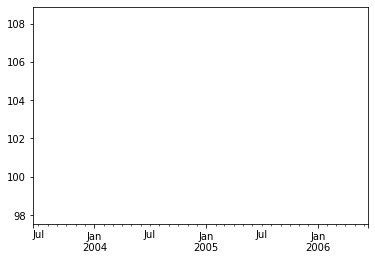

In [82]:
df['GHI'].plot()

<br>
It is possible to save a DataFrame in numerous formats. Here it is shown how to save it as a *Pandas pickle* which we use in the following tutorials.

In [70]:
%%time
df.to_pickle('./tmpData/{}_data.pkl'.format(ID)) # save the DataFrame in the Pandas pickle format


# todo: include the name and information of the station in the saved file.

Wall time: 393 ms


<br><br>

***
Once all the data is combined into one DataFrame, manipulation and plotting become relatively easy tasks.

As an example, the first month of the GHI, DHI, and BNI is plotted with the original 1 minute resolution:

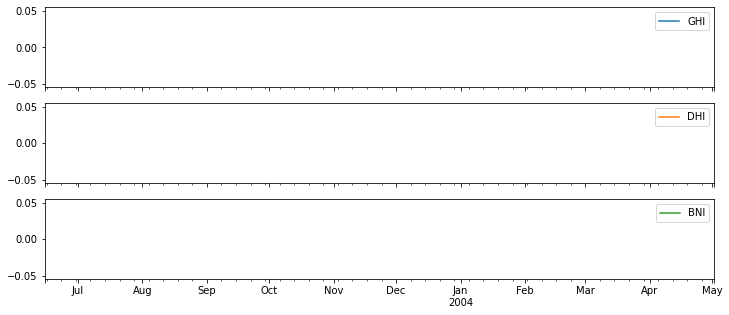

In [71]:
_ = df.loc[:'2004-05-01', ['GHI','DHI','BNI']].plot(figsize=(12,5), subplots=True)

Plotting the monthly average irradiance as a bar chart, can be done in one line as well:

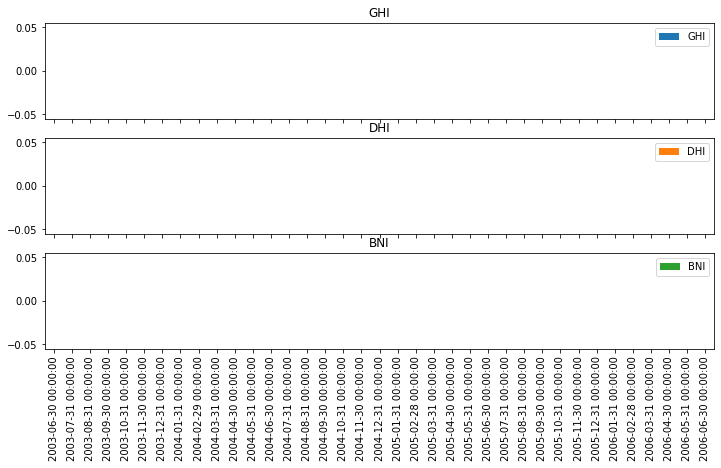

In [62]:
_ = df[['GHI','DHI','BNI']].resample('1M').mean().plot(figsize=(12,6), kind='bar', subplots=True)

A common quality check is the comparison of GHI to the sum of the DHI and the horizontal component of BNI:

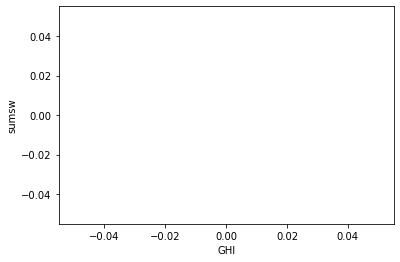

In [72]:
df['sumsw'] = df['DHI'] + df['BNI']*np.cos(df['THETA_Z']) # GHI calculated from DHI and BNI

_ = df[df['THETA_Z']<80].plot.scatter(x='GHI', y='sumsw', s=1)